In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import functools

In [1]:
!pip install tensorflow==2.14 tensorflow-hub==0.15

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 717.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 138.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: tensorflow-hub
    Found existing installation: tensorflow-hub 0.16.1
    Uninstalling tensorflow-hub-0.16.1:
      Successfully uninstalled tensorflow-hub-0.16.1
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0

In [3]:
(train_ds, valid_ds), info = tfds.load("oxford_flowers102", split=["train", "validation"], as_supervised=True, with_info=True)
int_to_class_label = info.features['label'].int2str


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.IONUR3_2.1.1/oxford_flowers102-train.tfrecord…

Generating test examples...:   0%|          | 0/6149 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.IONUR3_2.1.1/oxford_flowers102-test.tfrecord*…

Generating validation examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.IONUR3_2.1.1/oxford_flowers102-validation.tfr…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


In [4]:
CLASSES_TO_CONSIDER = list(range(20)) # first 20 classes
IMG_WIDTH = IMG_HEIGHT = 256

def preprocess_image(image, label, height, width):
    image = tf.image.resize_with_crop_or_pad(image, target_height=height, target_width=width)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def filter_by_classes(img, label):
    bools = tf.equal(label, CLASSES_TO_CONSIDER)
    return tf.reduce_any(bools)


partial_preprocess_image = functools.partial(preprocess_image, height=IMG_HEIGHT, width=IMG_WIDTH)
train_ds = train_ds.filter(filter_by_classes).map(partial_preprocess_image).cache().shuffle(buffer_size=1000)
valid_ds = valid_ds.filter(filter_by_classes).map(partial_preprocess_image).cache().shuffle(buffer_size=1000)


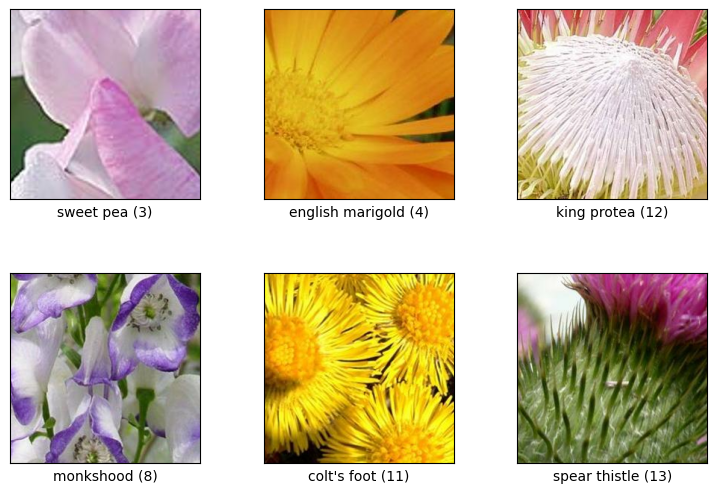

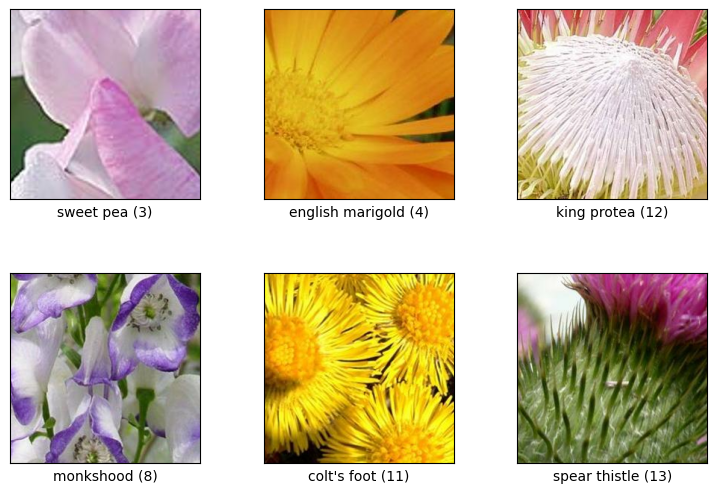

In [5]:

tfds.show_examples(train_ds, ds_info=info, rows=2, cols=3)

In [6]:

def get_x_y_from_ds(ds):
    x, y = [], []
    for img, label in ds.cache().as_numpy_iterator():
        x.append(img)
        y.append(label)

    return np.array(x), np.array(y)

x_train, y_train = get_x_y_from_ds(train_ds)
x_test, y_test = get_x_y_from_ds(valid_ds)
print(len(x_train), len(y_train), len(x_test), len(y_test))

200 200 200 200


In [7]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px

def plot_embeddings(features, labels):
    pca = TSNE(n_components=2, learning_rate='auto', init='pca')
    reduced_features = pca.fit_transform(features)
    str_labels = list(map(int_to_class_label, labels))
    fig = px.scatter(x=reduced_features[:,0], y=reduced_features[:,1], color=str_labels, symbol=labels)
    fig.show()

In [8]:
MODEL_URL = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"


In [9]:
vectorizer = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL, trainable=False)
])
vectorizer.build([None, IMG_HEIGHT, IMG_WIDTH, 3])
vectorizer.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              23564800  
                                                                 
Total params: 23564800 (89.89 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [10]:
pre_trained_features = vectorizer.predict(x_test)
plot_embeddings(features=pre_trained_features, labels=y_test)

7/7 [==============================] - 38s 5s/step


In [11]:
from sklearn.neighbors import NearestNeighbors
def get_knn(features):
    knn = NearestNeighbors(n_neighbors=5, metric="cosine")
    knn.fit(features)
    return knn

import ipywidgets as w
def show_similar_images(images, labels, vectorizer, knn, start_image_idx, n_inputs=5, n_neighbors=10):
    input_images = images[start_image_idx:start_image_idx+n_inputs]
    features = vectorizer.predict(input_images)
    knn_output = knn.kneighbors(features, n_neighbors=n_neighbors)

    images_with_distances_and_nbors = zip(input_images, *knn_output)

    fig, axes = plt.subplots(len(input_images), n_neighbors+1, figsize=(20, len(input_images)*4))

    for i, (image, distances, nbors) in enumerate(images_with_distances_and_nbors):
        for j in range(n_neighbors+1):
            ax = axes[i, j]
            img = (image if j==0 else images[nbors[j-1]])
            if j == 0:
                ax.set_title("Input Image")
            else:
                ax.set_title(f"Sim: {1-distances[j-1]:.2f}")
                ax.set_xlabel(f"lbl: {labels[nbors[j-1]]}")
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            ax.imshow(img)


interactive(children=(IntSlider(value=0, continuous_update=False, description='start_image_idx', max=199), Int…

<function __main__.show_similar_images(images, labels, vectorizer, knn, start_image_idx, n_inputs=5, n_neighbors=10)>

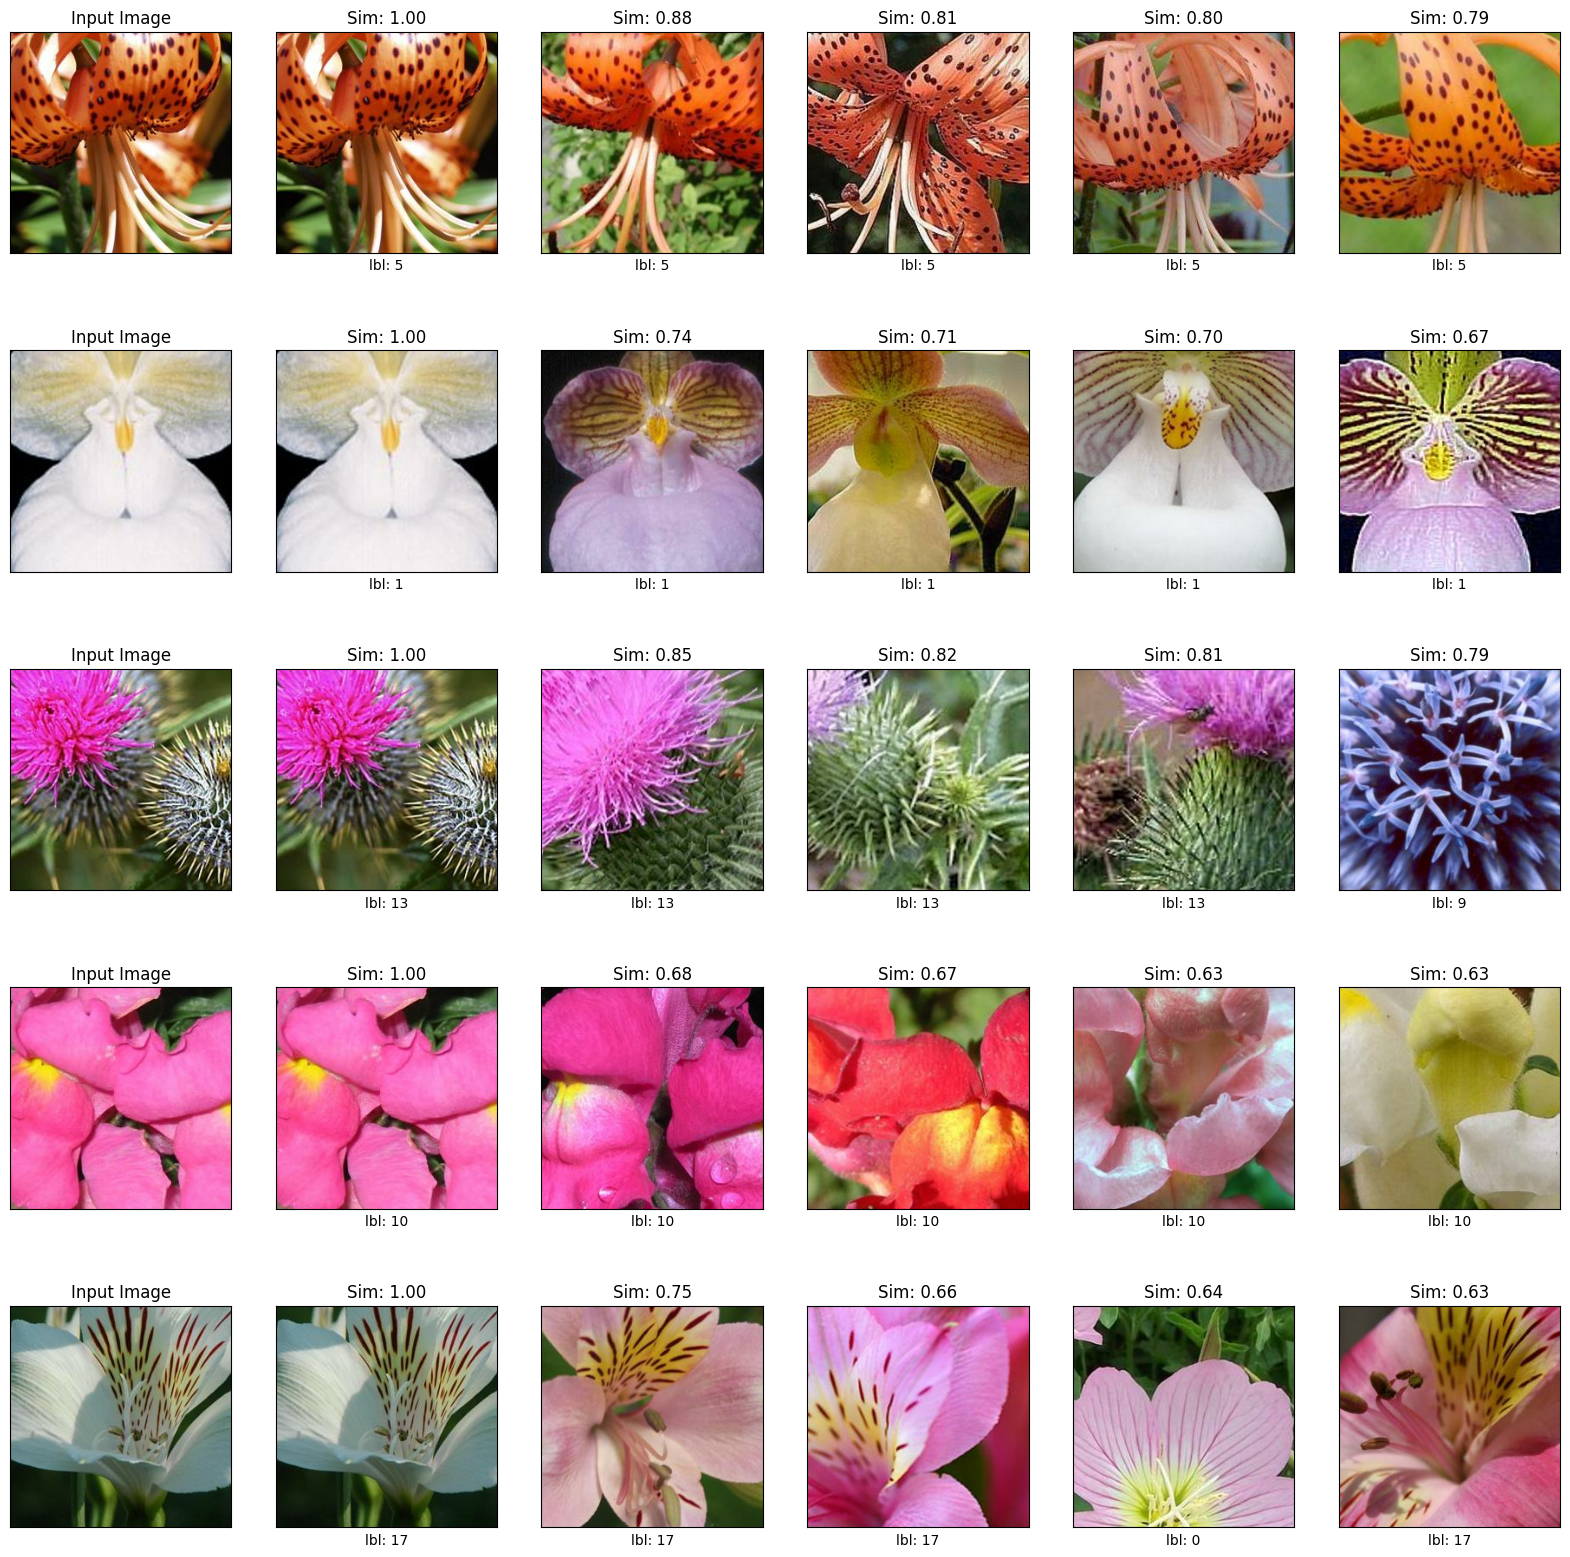

In [12]:
pretrained_knn = get_knn(features=pre_trained_features)
w.interact(show_similar_images, images=w.fixed(x_test), labels=w.fixed(y_test), vectorizer=w.fixed(vectorizer), knn=w.fixed(pretrained_knn),
    start_image_idx=w.IntSlider(max=len(x_test)-1, continuous_update=False),
    n_inputs=w.IntSlider(min=2, value=5, max=10, continuous_update=False),
    n_neighbors=w.IntSlider(min=2, value=5, max=10, continuous_update=False),
) # 74 has weird results

In [13]:
tuned_vectorizer = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    hub.KerasLayer(MODEL_URL, trainable=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(384, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
])
tuned_vectorizer.build([None, IMG_HEIGHT, IMG_WIDTH, 3])
tuned_vectorizer.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 256, 256, 3)       0         
 ation)                                                          
                                                                 
 keras_layer_1 (KerasLayer)  (None, 2048)              23564800  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 384)               786816    
                                                                 
 lambda (Lambda)             (None, 384)               0         
                                                      

In [14]:
from collections import defaultdict
import random

def get_training_batch(images, labels, batch_size=128, n_examples_per_class=3):
    examples_per_class = defaultdict(list)
    for x, y in zip(images, labels):
        examples_per_class[y].append(x)

    while True:
        batch_X, batch_y = [], []
        while len(batch_X) < batch_size:
            for cls, examples in examples_per_class.items():
                n_sample = min(n_examples_per_class, (batch_size - len(batch_X)))
                if n_sample == 0:
                    break
                samples = random.sample(examples, k=n_sample)
                batch_X.extend(samples)
                batch_y.extend([cls] * len(samples))

        yield np.array(batch_X), np.array(batch_y)

In [15]:
! pip install tensorflow_addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.8 MB/s eta 0:00:00


In [17]:
bs = 64
n_examples_per_class = 3
initial_lr = 0.0001
epochs = 10
import tensorflow_addons as tfa

tuned_vectorizer.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr),
                         loss=tfa.losses.TripletSemiHardLoss())

history = tuned_vectorizer.fit(get_training_batch(images=x_train, labels=y_train, batch_size=bs, n_examples_per_class=n_examples_per_class),
                               callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)],
                               epochs=epochs,
                               steps_per_epoch=len(x_train)//bs,
                               validation_data=(x_test, y_test),
                               validation_batch_size=bs,
                              )

Epoch 1/10
3/3 [==============================] - 197s 67s/step - loss: 1.1349 - val_loss: 1.1191
Epoch 2/10
3/3 [==============================] - 183s 66s/step - loss: 1.0943 - val_loss: 1.0932
Epoch 3/10
3/3 [==============================] - 183s 66s/step - loss: 1.0395 - val_loss: 1.0704
Epoch 4/10
3/3 [==============================] - 182s 66s/step - loss: 1.0052 - val_loss: 1.0469
Epoch 5/10
3/3 [==============================] - 181s 65s/step - loss: 0.9541 - val_loss: 1.0230
Epoch 6/10
3/3 [==============================] - 182s 66s/step - loss: 0.8896 - val_loss: 1.0023
Epoch 7/10
3/3 [==============================] - 181s 66s/step - loss: 0.8671 - val_loss: 0.9844
Epoch 8/10
3/3 [==============================] - 183s 66s/step - loss: 0.8548 - val_loss: 0.9565
Epoch 9/10
3/3 [==============================] - 182s 66s/step - loss: 0.7817 - val_loss: 0.9282
Epoch 10/10
3/3 [==============================] - 182s 66s/step - loss: 0.7514 - val_loss: 0.9030


In [18]:
frozen_features = tuned_vectorizer.predict(x_test)
plot_embeddings(features=frozen_features, labels=y_test)

7/7 [==============================] - 36s 5s/step


1/1 [==============================] - 2s 2s/step


<function __main__.show_similar_images(images, labels, vectorizer, knn, start_image_idx, n_inputs=5, n_neighbors=10)>

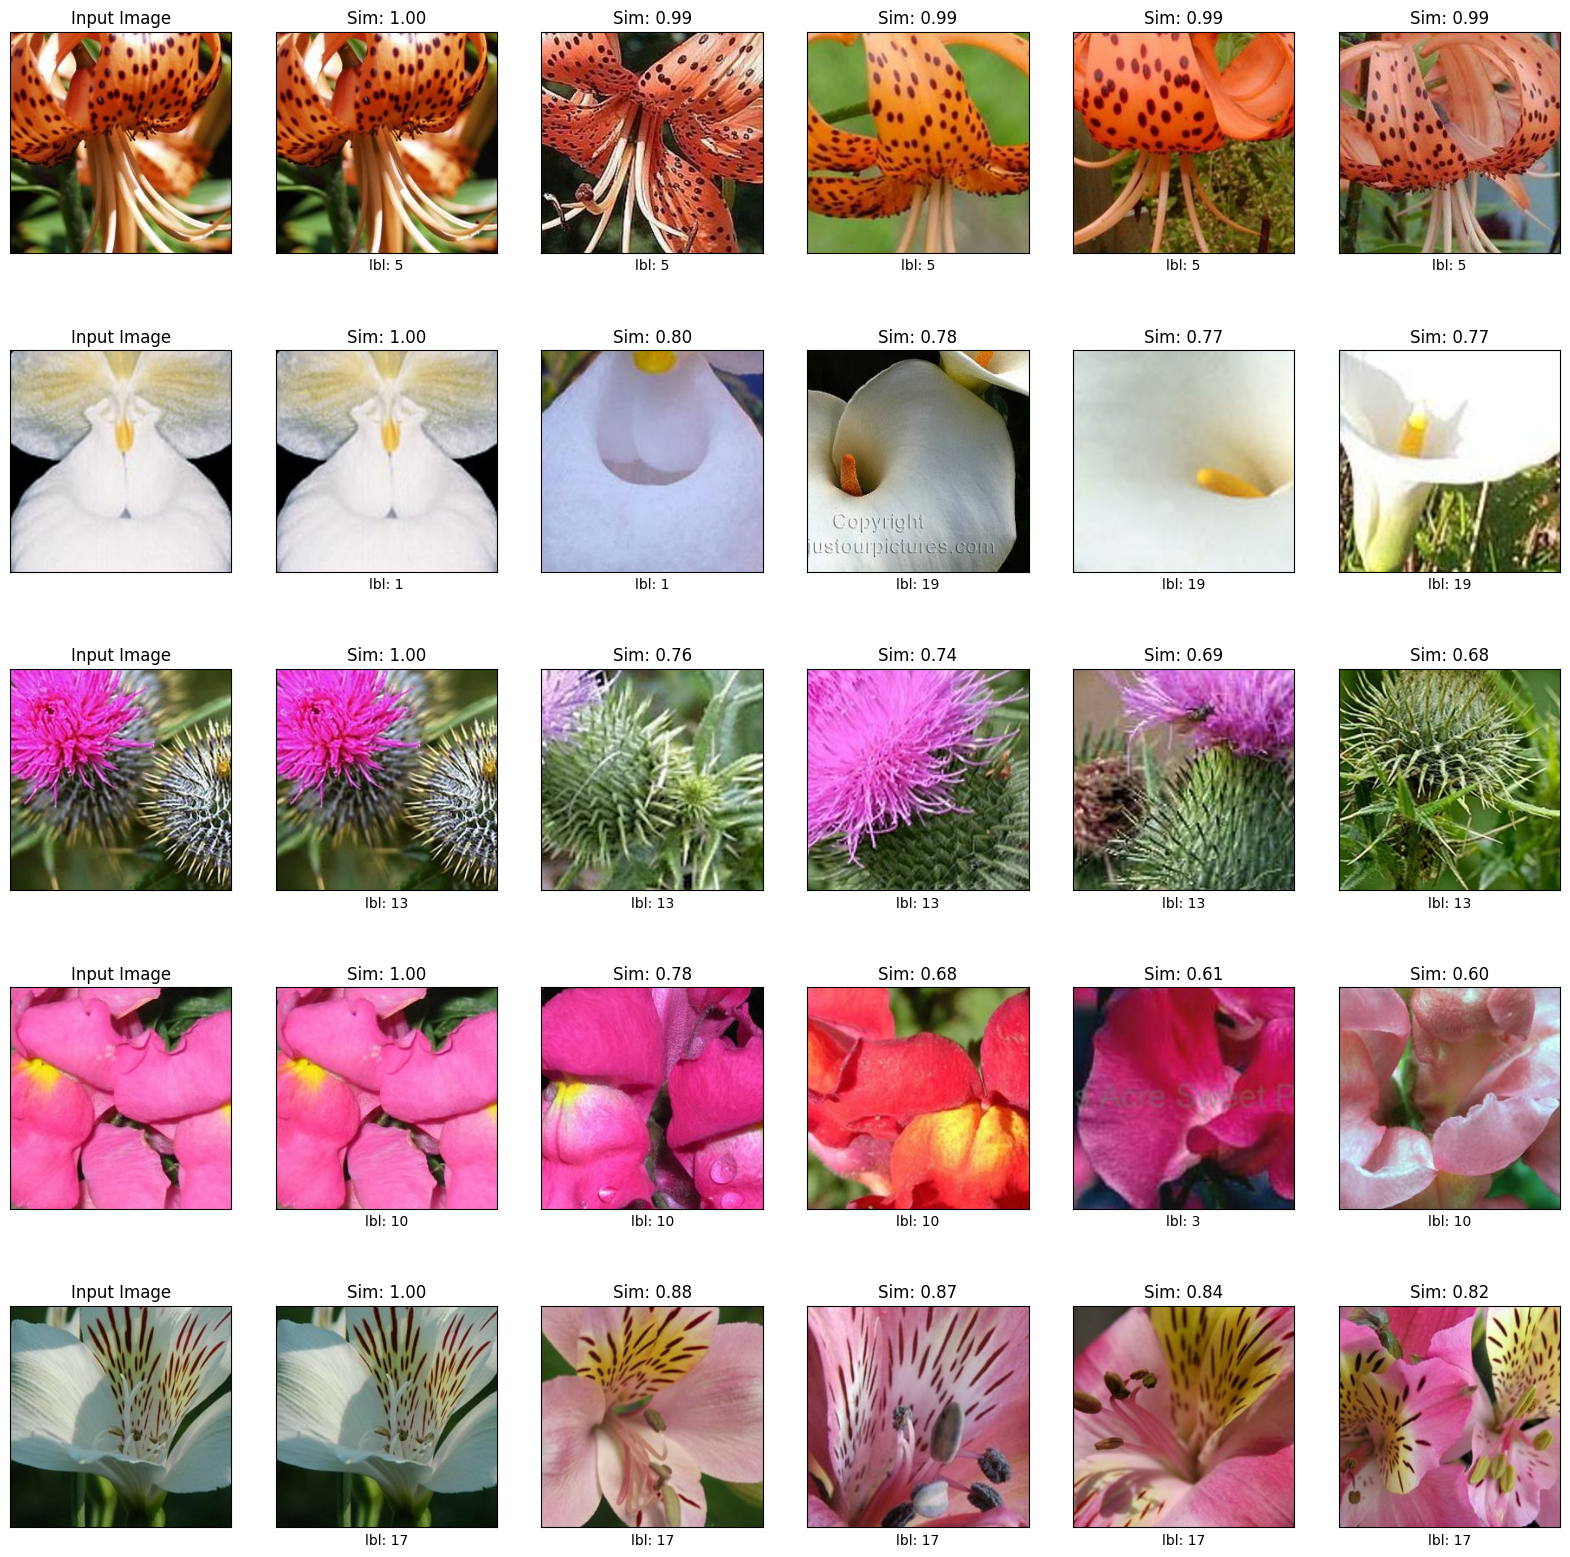

In [19]:
frozen_knn = get_knn(features=frozen_features)
w.interact(show_similar_images, images=w.fixed(x_test), labels=w.fixed(y_test), vectorizer=w.fixed(tuned_vectorizer), knn=w.fixed(frozen_knn),
    start_image_idx=w.IntSlider(max=len(x_test)-1, continuous_update=False),
    n_inputs=w.IntSlider(min=2, value=5, max=10, continuous_update=False),
    n_neighbors=w.IntSlider(min=2, value=5, max=10, continuous_update=False),
)